In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import matplotlib
from numpy import inf
from scipy import stats
import scipy as sp
import math

matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'

# 유동인구로 보는 행동변화 

# 1. 데이터 불러오기

오프라인 + 온라인 소비 데이터

In [2]:
card = pd.read_csv("../data/original_data/processed_data/CARD_SPENDING_RESIDENT_KOR.csv")
cj = pd.read_excel('../data/original_data/raw_data/05_물류데이터(CJ올리브네트웍스)/2020 빅콘테스트_CJ올리브네트웍스_제공DB.xlsx')

유동인구 데이터의 연령대 카드와 맞추기

In [3]:
# load data
flow_201902 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201902.csv", sep='|')
flow_201903 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201903.csv", sep='|')
flow_201904 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201904.csv", sep='|')
flow_201905 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201905.csv", sep='|')
flow_202002 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202002.csv", sep='|')
flow_202003 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202003.csv", sep='|')
flow_202004 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202004.csv", sep='|')
flow_202005 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202005.csv", sep='|')
flow_for_card = pd.concat([flow_201902, flow_201903, flow_201904, flow_201905, flow_202002, flow_202003, flow_202004, flow_202005], axis=0)

# 카드 데이터와의 연령 맞추기 위해 가공
# 카드데이터에서 25세 미만은 모두 20으로 표기
# 카드데이터에서 65에 이상은 65로 표기
man_under_25  = ['MAN_FLOW_POP_CNT_0004', 'MAN_FLOW_POP_CNT_0509', 'MAN_FLOW_POP_CNT_1014', 'MAN_FLOW_POP_CNT_1519', 'MAN_FLOW_POP_CNT_2024']
wman_under_25 = ['WMAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0509', 'WMAN_FLOW_POP_CNT_1014', 'WMAN_FLOW_POP_CNT_1519', 'WMAN_FLOW_POP_CNT_2024']
man_over_65   = ['MAN_FLOW_POP_CNT_6569', 'MAN_FLOW_POP_CNT_70U']
wman_over_65  = ['WMAN_FLOW_POP_CNT_6569', 'WMAN_FLOW_POP_CNT_70U']

flow_for_card['MAN_FLOW_POP_CNT_20L'] = flow_for_card[man_under_25].sum(axis=1) # for card
flow_for_card['WMAN_FLOW_POP_CNT_20L'] = flow_for_card[wman_under_25].sum(axis=1) # for card
flow_for_card['MAN_FLOW_POP_CNT_65U'] = flow_for_card[man_over_65].sum(axis=1)
flow_for_card['WMAN_FLOW_POP_CNT_65U'] = flow_for_card[wman_over_65].sum(axis=1)
flow_for_card = flow_for_card.drop(man_under_25+wman_under_25+man_over_65+wman_over_65, axis=1)

# melt
flow_for_card = pd.melt( flow_for_card, 
                        id_vars=['STD_YM', 'STD_YMD', 'HDONG_CD', 'HDONG_NM'], 
                        value_vars=flow_for_card.columns[4:].tolist())
flow_for_card.rename(columns={"value":"FLOW"}, inplace=True)

# 성별 추출 + 연령 추출
sex_dict = {"MAN":"M", "WMAN":"F"}
flow_for_card['SEX_CD'] = flow_for_card['variable'].apply(lambda x:sex_dict[x.split('_')[0]])
flow_for_card['AGE_CD'] = flow_for_card['variable'].apply(lambda x:x.split('_')[-1][:2])

In [4]:
# 카드 데이터와의 연령 맞추기 위해 가공
# 카드데이터에서 25세 미만은 모두 20으로 표기
# 카드데이터에서 65에 이상은 65로 표기
flow_living_for_card = pd.read_csv("../data/external_data/processed_data/local_people_data.csv")

man_under_25  = ['남자_0009세생활인구수', '남자_1014세생활인구수', '남자_1519세생활인구수', '남자_2024세생활인구수']
wman_under_25 = ['여자_0009세생활인구수', '여자_1014세생활인구수', '여자_1519세생활인구수', '여자_2024세생활인구수']
man_over_65   = ['남자_6569세생활인구수', '남자_70세이상생활인구수']
wman_over_65  = ['여자_6569세생활인구수', '여자_70세이상생활인구수']

flow_living_for_card['남자_0025세생활인구수'] = flow_living_for_card[man_under_25].sum(axis=1) # for card
flow_living_for_card['여자_0025세생활인구수'] = flow_living_for_card[wman_under_25].sum(axis=1) # for card
flow_living_for_card['남자_65세이상생활인구수'] = flow_living_for_card[man_over_65].sum(axis=1)
flow_living_for_card['여자_65세이상생활인구수'] = flow_living_for_card[wman_over_65].sum(axis=1)
flow_living_for_card = flow_living_for_card.drop(man_under_25+wman_under_25+man_over_65+wman_over_65, axis=1)

# melt
flow_living_for_card = pd.melt( flow_living_for_card, 
                               id_vars=['STD_DD', '시간대구분', 'G_DNG_NM'], 
                               value_vars=['남자_2529세생활인구수', '남자_3034세생활인구수', '남자_3539세생활인구수',
                                           '남자_4044세생활인구수', '남자_4549세생활인구수', '남자_5054세생활인구수',
                                           '남자_5559세생활인구수', '남자_6064세생활인구수', '여자_2529세생활인구수',
                                           '여자_3034세생활인구수', '여자_3539세생활인구수', '여자_4044세생활인구수',
                                           '여자_4549세생활인구수', '여자_5054세생활인구수', '여자_5559세생활인구수',
                                           '여자_6064세생활인구수', '남자_0025세생활인구수', '여자_0025세생활인구수',
                                           '남자_65세이상생활인구수','여자_65세이상생활인구수'])
flow_living_for_card.rename(columns={"value":"FLOW"}, inplace=True)

# 성별 추출 + 연령 추출
sex_dict = {"남자":"M", "여자":"F"}
flow_living_for_card['SEX_CD'] = flow_living_for_card['variable'].apply(lambda x:sex_dict[x.split('_')[0]])
flow_living_for_card['AGE_CD'] = flow_living_for_card['variable'].apply(lambda x:int(x.split('_')[-1][:2]))
flow_living_for_card['AGE_CD'] = flow_living_for_card['AGE_CD'].replace(0, 20)
flow_living_for_card['DONG'] = flow_living_for_card['G_DNG_NM'].map(lambda x:x.split()[-1])

# 2. 처리 함수

In [5]:
region = pd.read_csv('../data/external_data/processed_data/region_v2.csv')

In [6]:
dong_to_work = {}
dong_to_outlet = {}

for dong, work, outlet in region[['HDONG_NM', 'work', 'outlet']].values:
    dong_to_work[dong] = work
    dong_to_outlet[dong] = outlet  

In [7]:
def check(x):
    # 코로나 전
    if (x.month==2 and x.day<21):
        return 0
    # 확산기간
    elif ((x.month==2 and x.day>=21) or (x.month==3 and x.day<=15)):
        return 1
    # 완화기간
    elif ((x.month==3 and x.day>=22) or (x.month==4) or (x.month==5 and x.day<=5)):
        return 2
    # 회복기간
    elif (x.month==5 and x.day>=6):
        return 3
    # 확산기간과 회복기간 그 중간 일주일
    else:
        return 4

In [8]:
def add_column(dataframe, dong_column, date_column, date_format = '%Y%m%d'):
    weekdays=list("월화수목금토일")
    # 날짜와 관련된 column 추가
    dataframe[date_column] = pd.to_datetime(dataframe[date_column], format=date_format)
    dataframe['YEAR'] = dataframe[date_column].dt.year # 년도
    dataframe['MONTH'] = dataframe[date_column].dt.month # 월
    dataframe['WEEK_NUM'] = dataframe[date_column].dt.weekofyear # 주차
    dataframe['WEEKDAY'] = dataframe[date_column].dt.dayofweek.apply(lambda x : '_'.join([str(x),weekdays[x]])) # 요일

    dataframe['work'] = dataframe[dong_column].apply(lambda x:dong_to_work[x]) # work 지역
    dataframe['outlet'] = dataframe[dong_column].apply(lambda x:dong_to_outlet[x]) # outlet 지역
    dataframe['STD_WEEK'] = dataframe['YEAR']*100 + dataframe['WEEK_NUM'] # 년도 + 주차
    dataframe['STD_WEEK'] = dataframe['STD_WEEK'].astype(int).astype(str) 
    dataframe['period'] = dataframe[date_column].apply(lambda x:check(x)) # 기간
    dataframe['weekday_weekend'] = dataframe['WEEKDAY'].apply(lambda x:x in ['0_월', '1_화', '2_수', '3_목', '4_금']) # 평일/주말
    dataframe[date_column] = dataframe[date_column].astype(str) 
    dataframe[date_column] = dataframe[date_column].apply(lambda x:str(x).split()[0])
    return dataframe

In [9]:
def pvalue_check(p_value, alpha=0.05):
    if(p_value < alpha):
        return "H0 기각"
    else:
        return "H0 채택"

In [10]:
cj['HDNG_NM'] = cj['HDNG_NM'].replace("신당제5동", "신당5동")
cj = add_column(cj, 'HDNG_NM', 'DL_YMD', '%y%m%d')
card = add_column(card, 'DONG_CD', 'STD_DD', '%Y%m%d')

In [11]:
flow_for_card = add_column(flow_for_card, 'HDONG_NM', 'STD_YMD', '%Y%m%d')
flow_living_for_card = add_column(flow_living_for_card, 'DONG', 'STD_DD', '%Y-%m-%d')

<br><br>

---

<br><br>

# 3. 대형아울렛
**오프라인에서 온라인으로 소비변환 보고싶다**
<br><br>
<정리>
- _**전체적인 오프라인 소비 / 온라인 소비의 추세**_
    1. 오프라인의 경우 감소추세
    2. 온라인의 경우 증가추세  
    를 예상했지만 그렇지 않았다.

<br><br>
- _**타격기간**_
    1. 오프라인 소비횟수 감소율 / 온라인 소비횟수 증가율 
        - 오프라인에서 감소한만큼 온라인에서 증가하였는가?  
          
        이러하기를 기대했지만, 그렇지 않았다.  
        옷을 가장 많이 구매하는 연령대는 20-24, 25-29세인데,  
        20~24세의 경우 대학생 -> 비대면 강의가 진행됨에 따라 **옷 소비의 필요성 저하 -> 온라인 소비로 이어지지 X**  
        그냥 단순히 **옷 구매의 필요성 저하가 소비 감소의 원인으로 예상 .. **
<br><br>

## 1) 전체적인 오프라인/온라인 소비의 추세

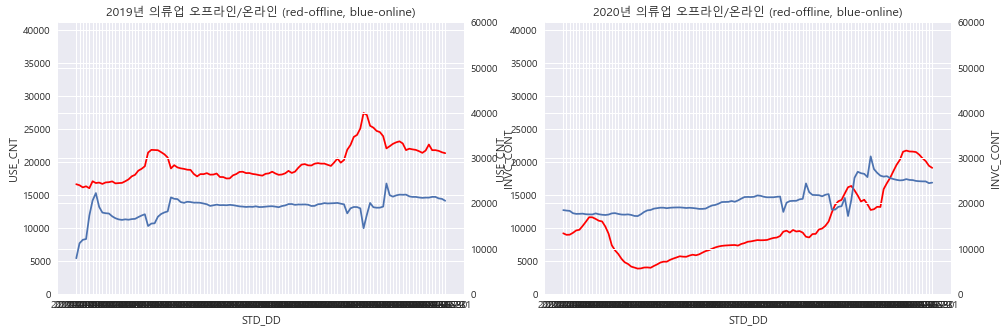

In [12]:
# 대형아울렛 정의 시 '대형마트 개소', '백화점 개소', '쇼핑센터 개소', "복합쇼핑몰 개소"를 고려했기 때문에
# 백화점의 대부분의 업종을 차지하는 의복/신변잡화 카테고리 위주로 관찰해보려고 했다.
card_columns = ['의복', '신변잡화']
cj_columns = ['패션잡화', '패션의류']

# 데이터 추출
card_temp = card.loc[card['MCT_CAT_CD'].apply(lambda x:x in card_columns)]
card_temp = card_temp.groupby(['YEAR', 'STD_DD'])[['USE_CNT']].sum().reset_index()
card_temp_2019 = card_temp.query('YEAR==2019').set_index('STD_DD').rolling(7).mean().dropna().reset_index()
card_temp_2020 = card_temp.query('YEAR==2020').set_index('STD_DD').rolling(7).mean().dropna().reset_index()

cj_temp = cj.loc[cj['DL_GD_LCLS_NM'].apply(lambda x:x in cj_columns)]
cj_temp = cj_temp.groupby(['YEAR', 'DL_YMD'])[['INVC_CONT']].sum().reset_index()
cj_temp_2019 = cj_temp.query('YEAR==2019').set_index('DL_YMD').rolling(7).mean().dropna().reset_index()
cj_temp_2020 = cj_temp.query('YEAR==2020').set_index('DL_YMD').rolling(7).mean().dropna().reset_index()

# 시각화
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
axes_twinx = [axes[0].twinx(), axes[1].twinx()]

sns.lineplot(x='STD_DD', y='USE_CNT', data=card_temp_2019, color='red', ax=axes[0])
sns.lineplot(x='STD_DD', y='USE_CNT', data=card_temp_2020, color='red', ax=axes[1])
sns.lineplot(x='DL_YMD', y='INVC_CONT', data=cj_temp_2019, ax=axes_twinx[0])
sns.lineplot(x='DL_YMD', y='INVC_CONT', data=cj_temp_2020, ax=axes_twinx[1])

axes[0].set_ylim([0, card_temp['USE_CNT'].max()*1.1])
axes[1].set_ylim([0, card_temp['USE_CNT'].max()*1.1])
axes_twinx[0].set_ylim([0, cj_temp['INVC_CONT'].max()*1.1])
axes_twinx[1].set_ylim([0, cj_temp['INVC_CONT'].max()*1.1])

axes[0].set_title("2019년 의류업 오프라인/온라인 (red-offline, blue-online)")
axes[1].set_title("2020년 의류업 오프라인/온라인 (red-offline, blue-online)")
plt.show()

- **송장건수는 작년 수준에서 살짝 증가하는 추세**를 보이기는 하지만 크게 증가하지는 않았다.
- **오프라인 구매횟수**의 경우 코로나로 타격을 받긴 했지만, **최근에 이전 수준으로 회복**한 것으로 보인다.
    - 5월경에 의류 소비가 증가하였는데, 재난지원금의 효과 덕분인가?
    - 아니면 증가하는 추세 때문인가?
- 기간을 나눠서 의류 소비를 자세히 살펴보도록 한다.

<br><br>
## 2) 타격기간
- 오프라인에서 감소한만큼 온라인에서 증가하였는가? -> 아니오

### 온/오프라인 구매횟수 시각화

In [13]:
def graph_card_invc(graph_start_day, graph_end_day, card_columns, cj_columns,):
    title = "/".join(card_columns)
    diffusion_start_day = "2020-02-21"
    diffusion_end_day = "2020-03-15"

    card_D = card.loc[(graph_start_day<=card['STD_DD']) & (card['STD_DD']<=graph_end_day)]
    card_D = card_D.loc[card_D['MCT_CAT_CD'].apply(lambda x:x in card_columns)]
    card_D = card_D.groupby(['STD_DD'])[['USE_CNT']].sum().reset_index()
    card_D_rolling = card_D.groupby(['STD_DD'])[['USE_CNT']].sum().rolling(7).mean().dropna().reset_index()
    
    cj_D = cj.loc[(graph_start_day<=cj['DL_YMD']) & (cj['DL_YMD']<=graph_end_day)]
    cj_D = cj_D.loc[cj_D['DL_GD_LCLS_NM'].apply(lambda x:x in cj_columns)]
    cj_D = cj_D.groupby(['DL_YMD'])[['INVC_CONT']].sum().reset_index()
    cj_D_rolling = cj_D.groupby(['DL_YMD'])[['INVC_CONT']].sum().rolling(7).mean().dropna().reset_index()
    
    plt.figure(figsize=(16, 5))
    ax = sns.lineplot(x='STD_DD', y='USE_CNT',data=card_D, label='card')
    ax_twinx = ax.twinx()
    sns.lineplot(x='DL_YMD', y='INVC_CONT', data=cj_D, ax=ax_twinx, color='red', label='invc')
    
    ax.legend(loc=2, fontsize=15)
    ax_twinx.legend(loc=1, fontsize=15)
    ax.axvspan(xmin=diffusion_start_day, xmax=diffusion_end_day, facecolor='#ff796c', alpha=0.2)
    ax.set_title(f"{graph_start_day}~{graph_end_day} {title} 온오프라인 구매횟수", size=15)
    plt.show()

    
    plt.figure(figsize=(16, 5))
    ax = sns.lineplot(x='STD_DD', y='USE_CNT',data=card_D_rolling, label='card')
    ax_twinx = ax.twinx()
    sns.lineplot(x='DL_YMD', y='INVC_CONT', data=cj_D_rolling, ax=ax_twinx, color='red', label='invc')
    ax.set_ylim([0, card_D_rolling['USE_CNT'].max()*1.1])
    ax_twinx.set_ylim([0, cj_D_rolling['INVC_CONT'].max()*1.1])

    ax.legend(loc=2, fontsize=15)
    ax_twinx.legend(loc=1, fontsize=15)
    ax.axvspan(xmin=diffusion_start_day, xmax=diffusion_end_day, facecolor='#ff796c', alpha=0.2)
    ax.set_title(f"{graph_start_day}~{graph_end_day} {title} 온오프라인 구매횟수 (rolling mean)", size=15)
    plt.show()

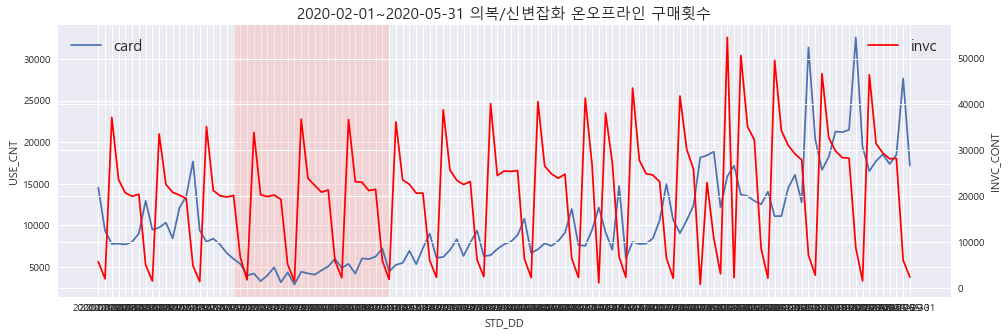

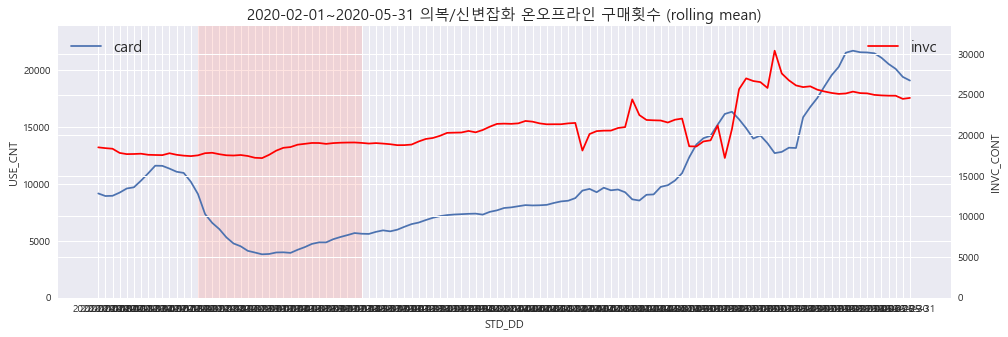

In [14]:
graph_start_day = "2020-02-01"
graph_end_day = "2020-05-31"
card_columns = ['의복', '신변잡화']
cj_columns = ['패션잡화', '패션의류']

graph_card_invc(graph_start_day, graph_end_day, card_columns, cj_columns)

- 위 그래프에서 빨간 부분이 코로나 확산기간에 속한다.
- 코로나로 오프라인에서의 의류소비가 감소한만큼, 온라인 의류소비가 증가할 것으로 예상하였으나,
- 온라인 의류 소비는 거의 증가하지 않았다.
- 여기에 의문을 가지고 연령대별로 소비횟수를 더 자세히 살펴보도록 하자.

### 월별+연령별 오프라인 소비횟수

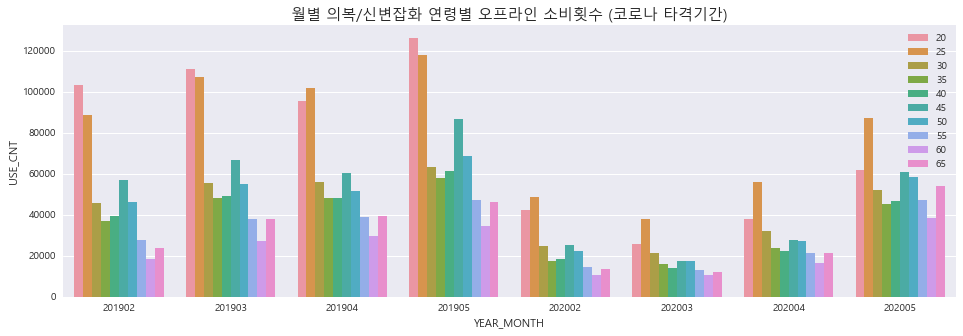

In [15]:
card_temp = card.loc[card['MCT_CAT_CD'].apply(lambda x:x in card_columns)]
card_temp['YEAR_MONTH'] = card_temp['YEAR']*100 + card_temp['MONTH']
card_temp = card_temp.groupby(['YEAR_MONTH', 'MONTH', 'AGE_CD'])[['USE_CNT']].sum().reset_index()

plt.figure(figsize=(16, 5))
sns.barplot(x='YEAR_MONTH', y='USE_CNT', hue='AGE_CD', data=card_temp)
plt.title("월별 {} 연령별 오프라인 소비횟수 (코로나 타격기간)".format('/'.join(card_columns)), size=15)
plt.legend(loc=1)
plt.show()

### 전년 동월 대비 올해 동월의 연령별 소비횟수 시각화

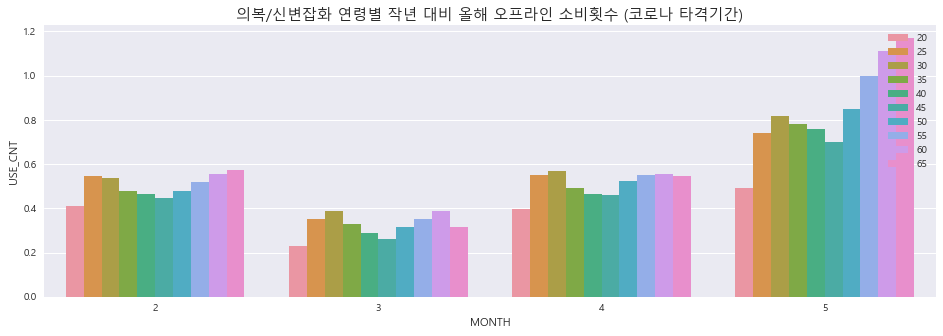

In [16]:
card_temp = card.loc[card['MCT_CAT_CD'].apply(lambda x:x in card_columns)]
card_temp['YEAR_MONTH'] = card_temp['YEAR']*100 + card_temp['MONTH']
card_temp = card_temp.groupby(['YEAR_MONTH', 'MONTH', 'AGE_CD'])[['USE_CNT']].sum().reset_index()
card_temp_2019 = card_temp.query('YEAR_MONTH<202000').set_index(['MONTH', 'AGE_CD'])[['USE_CNT']]
card_temp_2020 = card_temp.query('YEAR_MONTH>202000').set_index(['MONTH', 'AGE_CD'])[['USE_CNT']]
ratio = (card_temp_2020 / card_temp_2019).reset_index()

plt.figure(figsize=(16, 5))
sns.barplot(x='MONTH', y='USE_CNT', hue='AGE_CD', data=ratio)
plt.title("{} 연령별 작년 대비 올해 오프라인 소비횟수 (코로나 타격기간)".format('/'.join(card_columns)), size=15)
plt.legend(loc=1)
plt.show()

- 2019년에는 **20-25, 25-30세 연령대**의 의류 소비횟수가 다른 연령 대비 **2배**정도 높았다.
- 2020년에 **의류 소비횟수가 가장 많이 감소**한 연령대는 **20-25세**이다.
- 주소비층의 소비횟수가 가장 크게 감소하였기 때문에 코로나로 인한 의류 소비의 타격 정도가 큰 것이다.
<br><br>
- 의류 주소비층인 20-25세는 대학생인 경우가 많은데, 이 연령대의 소비수준이 작년 대비 40%로 줄어든 이유는
- 코로나로 비대면 강의가 진행됨에 따라 의류구매의 필요성이 낮아졌기 때문이라고 생각한다.
- 즉, 의류가 필요하지 않았기 때문에 오프라인 의류 구매가 줄어들었으며, 온라인으로의 소비전환 또한 발생하지 않았다고 해석할 수 있다.
- **즉, 코로나 확산기간동안 의류소비의 비대면 전환이 일어나지 않은 원인은 의류 구매 필요성의 하락일 것으로 예상된다**

<br><br>
## 3) 타격기간 이후

In [17]:
flow_temp = flow_for_card.groupby(['HDONG_NM', 'STD_YMD', 'YEAR', 'MONTH', 'WEEK_NUM', 'WEEKDAY', 'weekday_weekend'])[['FLOW']].sum().reset_index()
flow_temp = flow_temp.groupby(['HDONG_NM', 'STD_YMD', 'YEAR', 'MONTH', 'WEEK_NUM', 'weekday_weekend'])[['FLOW']].median().reset_index()

card_temp = card.query('(MCT_CAT_CD in ["의복", "신변잡화"]) and (period==2)')
card_temp = card_temp.groupby(['DONG_CD', 'STD_DD', 'YEAR', 'MONTH', 'WEEK_NUM', 'WEEKDAY', 'weekday_weekend'])[['USE_CNT']].sum().reset_index()
card_temp = card_temp.groupby(['DONG_CD', 'STD_DD', 'YEAR', 'MONTH', 'WEEK_NUM', 'weekday_weekend'])[['USE_CNT']].median().reset_index()

flow_card_merge = pd.merge(flow_temp, card_temp, how='inner', 
                           left_on=['HDONG_NM', 'STD_YMD', 'YEAR', 'MONTH', 'WEEK_NUM', 'weekday_weekend'],
                           right_on=['DONG_CD', 'STD_DD', 'YEAR', 'MONTH', 'WEEK_NUM', 'weekday_weekend'])
flow_card_merge['outlet'] = flow_card_merge['DONG_CD'].apply(lambda x:dong_to_outlet[x])

In [18]:
def get_corr_card_flow(query1, query2, card_agg_column):
    corr1_list = []
    corr2_list = []
    for dong in flow_card_merge['HDONG_NM'].unique():
        corr1 = np.corrcoef(x=flow_card_merge.query(f'HDONG_NM=="{dong}"').query(query1)['FLOW'], 
                            y=flow_card_merge.query(f'HDONG_NM=="{dong}"').query(query1)[card_agg_column])[0][1]
        corr2 = np.corrcoef(x=flow_card_merge.query(f'HDONG_NM=="{dong}"').query(query2)['FLOW'], 
                            y=flow_card_merge.query(f'HDONG_NM=="{dong}"').query(query2)[card_agg_column])[0][1]   
        if not(math.isnan(corr1)) and not(math.isnan(corr2)):
            corr1_list.append(corr1), corr2_list.append(corr2)
    print("FLOW와 {} 상관계수 ({}) : {}".format(card_agg_column, query1, round(sum(corr1_list)/len(corr1_list), 4)))
    print("FLOW와 {} 상관계수 ({}) : {}".format(card_agg_column, query2, round(sum(corr2_list)/len(corr2_list), 4)), '\n')

### 년도별 유동인구/소비횟수 상관관계

**GET1. 2019년 대비 2020년 유동인구와 의복/신변잡화 소비횟수 상관관계 짙어짐**

In [19]:
# 평일
get_corr_card_flow("(YEAR==2019) and (weekday_weekend==True)", 
                   "(YEAR==2020) and (weekday_weekend==True)", 'USE_CNT')

FLOW와 USE_CNT 상관계수 ((YEAR==2019) and (weekday_weekend==True)) : 0.0558
FLOW와 USE_CNT 상관계수 ((YEAR==2020) and (weekday_weekend==True)) : 0.0765 



In [20]:
# 주말
get_corr_card_flow("(YEAR==2019) and (weekday_weekend==False)", 
                   "(YEAR==2020) and (weekday_weekend==False)", 'USE_CNT')

FLOW와 USE_CNT 상관계수 ((YEAR==2019) and (weekday_weekend==False)) : 0.4298
FLOW와 USE_CNT 상관계수 ((YEAR==2020) and (weekday_weekend==False)) : 0.5081 



### 년도별 & 평일/주말 & 아울렛/비아울렛 상관관계

**GET2. 아울렛지역과 비아울렛지역의 유동인구와 소비횟수 상관관계를 구해본 결과,**
- **비아울렛 지역**에서 평일에는 유동인구와 상관관계X, 주말에는 양의 상관관계 존재
- **아울렛 지역**에서는 평일에는 양의 상관관계 약간 존재, 주말에는 비교적 강한 양의 상관관계 존재

In [21]:
# 유동인구와 소비횟수간의 상관관계
print("유동인구와 소비횟수간의 상관관계")
print("평일(월, 화, 수, 목, 금), 주말(토, 일) \n")

# 비아울렛지역
# 평일 (월, 화, 수, 목, 금)
print("--------------------- 비아울렛지역 ---------------------")
get_corr_card_flow("(YEAR==2019) and (weekday_weekend==True) and (outlet==0)", 
                   "(YEAR==2020) and (weekday_weekend==True) and (outlet==0)", 'USE_CNT')

# 주말 (토, 일)
get_corr_card_flow("(YEAR==2019) and (weekday_weekend==False) and (outlet==0)", 
                   "(YEAR==2020) and (weekday_weekend==False) and (outlet==0)", 'USE_CNT')

# 아울렛지역
# 평일 (월, 화, 수, 목, 금)
print("--------------------- 아울렛지역 ---------------------")
get_corr_card_flow("(YEAR==2019) and (weekday_weekend==True) and (outlet==1)", 
                   "(YEAR==2020) and (weekday_weekend==True) and (outlet==1)", 'USE_CNT')
# 주말 (토, 일)
get_corr_card_flow("(YEAR==2019) and (weekday_weekend==False) and (outlet==1)", 
                   "(YEAR==2020) and (weekday_weekend==False) and (outlet==1)", 'USE_CNT')

유동인구와 소비횟수간의 상관관계
평일(월, 화, 수, 목, 금), 주말(토, 일) 

--------------------- 비아울렛지역 ---------------------
FLOW와 USE_CNT 상관계수 ((YEAR==2019) and (weekday_weekend==True) and (outlet==0)) : 0.0175
FLOW와 USE_CNT 상관계수 ((YEAR==2020) and (weekday_weekend==True) and (outlet==0)) : 0.071 

FLOW와 USE_CNT 상관계수 ((YEAR==2019) and (weekday_weekend==False) and (outlet==0)) : 0.378
FLOW와 USE_CNT 상관계수 ((YEAR==2020) and (weekday_weekend==False) and (outlet==0)) : 0.4372 

--------------------- 아울렛지역 ---------------------
FLOW와 USE_CNT 상관계수 ((YEAR==2019) and (weekday_weekend==True) and (outlet==1)) : 0.1524
FLOW와 USE_CNT 상관계수 ((YEAR==2020) and (weekday_weekend==True) and (outlet==1)) : 0.0906 

FLOW와 USE_CNT 상관계수 ((YEAR==2019) and (weekday_weekend==False) and (outlet==1)) : 0.5526
FLOW와 USE_CNT 상관계수 ((YEAR==2020) and (weekday_weekend==False) and (outlet==1)) : 0.6761 



### 아울렛지역 유동인구, 소비횟수 산점도
- 아울렛지역에서 유동인구와 의류 소비횟수 간 상관관계는 2019년 대비 2020년에 짙어졌다.
- 코로나로 유동인구가 줄어들고 있는 상황에서 의류소비 위축이 당분간 지속될 것으로 보인다.

In [22]:
outlet_flow = flow_for_card.query('(outlet==1) and (period!=4)').groupby(['HDONG_NM', 'STD_YMD', 'YEAR', 'WEEKDAY', 'period'])[['FLOW']].sum().reset_index()
outlet_card = card.query('(outlet==1) and (period!=4)').groupby(['DONG_CD', 'STD_DD', 'YEAR', 'WEEKDAY', 'period'])[['USE_CNT']].sum().reset_index()
flow_card = pd.merge(outlet_flow, outlet_card, how='inner', 
                     left_on=['HDONG_NM', 'STD_YMD', 'YEAR', 'WEEKDAY', 'period'],
                     right_on=['DONG_CD', 'STD_DD', 'YEAR', 'WEEKDAY', 'period'])

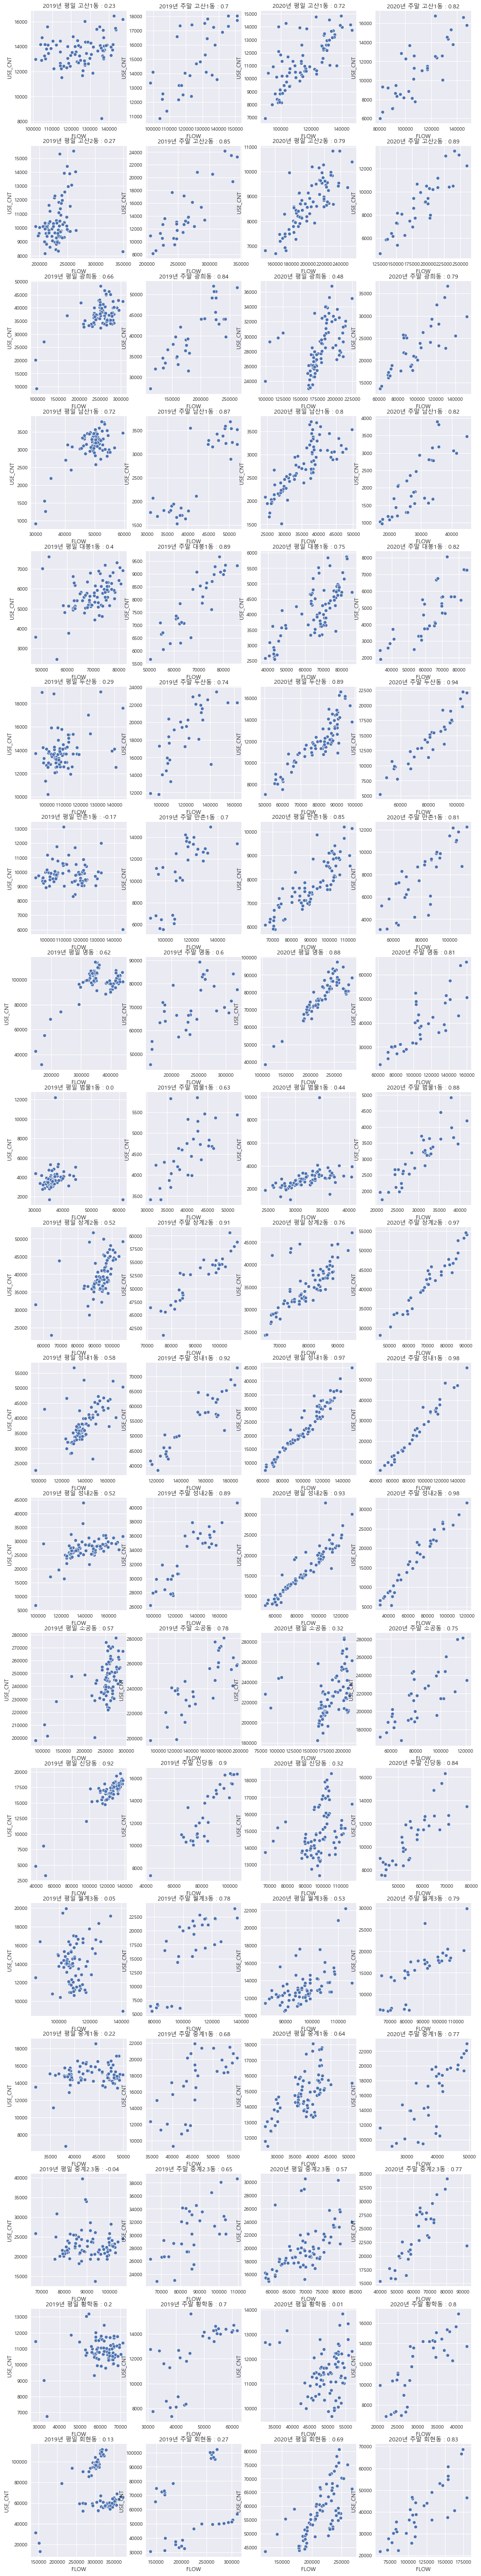

In [23]:
DONGs = flow_card['DONG_CD'].unique()

fig, axes = plt.subplots(nrows=len(DONGs), ncols=4, figsize=(16, 5*len(DONGs)))
for i, dong in enumerate(DONGs):
    for j, year in enumerate([2019, 2020]):
        query = f'(YEAR=={year}) and (DONG_CD=="{dong}") and (WEEKDAY not in ["5_토", "6_일"])'
        corr = np.round(np.corrcoef(flow_card.query(query)['FLOW'], flow_card.query(query)['USE_CNT'])[0][1], 2)
        sns.scatterplot(x=flow_card.query(query)['FLOW'],
                        y=flow_card.query(query)['USE_CNT'], ax=axes[i][j*2])
        axes[i][j*2].set_title(f"{year}년 평일 {dong} : {corr}")
        
        query = f'(YEAR=={year}) and (DONG_CD=="{dong}") and (WEEKDAY in ["5_토", "6_일"])'
        corr = np.round(np.corrcoef(flow_card.query(query)['FLOW'], flow_card.query(query)['USE_CNT'])[0][1], 2)
        sns.scatterplot(x=flow_card.query(query)['FLOW'],
                        y=flow_card.query(query)['USE_CNT'], ax=axes[i][j*2+1])
        axes[i][j*2+1].set_title(f"{year}년 주말 {dong} : {corr}")